In [11]:
%pylab inline

import pandas as pd
import pandas_datareader.data as web
import scipy.stats as stat

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense

rcParams['figure.figsize'] = (12,8)
rcParams['axes.grid'] = True

Populating the interactive namespace from numpy and matplotlib


In [2]:
def split_by_date(X,y,date_split):
    return X.loc[:date_split], X.loc[date_split:], y.loc[:date_split], y.loc[date_split:]

In [3]:
# Gather data for some ETFs to look at
names = ['XOP','XBI','OIH','IBB','USO']
px = web.get_data_yahoo(['^GSPC']+names,'2006-06-23','2019-11-27')['Adj Close']

# Compute log returns and 1y variances
logR = np.log(px/px.shift(1))
N = 252
variances = ((logR**2).rolling(N).sum()*252/N).iloc[N:]

In [6]:
# Explain XOP variance by linear combination of USO var and SPX var
#X = np.stack((variances['USO'],variances['^GSPC'],np.sqrt(variances['^GSPC']*variances['USO'])), axis=-1)
X = np.stack((variances['USO'],variances['^GSPC']), axis=-1)
X = pd.DataFrame(X,index=variances.index)
y = variances['XOP']

#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Train on data through EOY 2016, test on data 2017-present
X_train, X_test, y_train, y_test = split_by_date(X,y,'2017-01-01')

print('train size: %d'%len(X_train))
print('test size:  %d'%len(X_test))

train size: 2398
test size:  732


In [7]:
# Fit ordinary least squares on the training data, what are the parameters?
ols = linear_model.LinearRegression()
ols.fit(X_train,y_train)
print(ols.coef_)

[0.70017105 1.69977689]


In [8]:
# What is the R^2 of the OLS fit on the test data?
print('explained variance: %0.2f%%'%(100*r2_score(ols.predict(X_test),y_test)))

explained variance: 83.64%


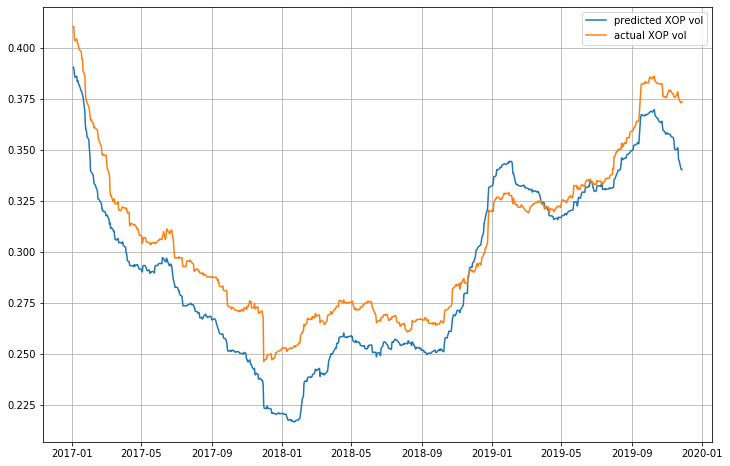

In [12]:
plot(y_test.index, np.sqrt(ols.predict(X_test)),label='predicted XOP vol')
plot(np.sqrt(y_test),label='actual XOP vol')
legend(loc='upper right')

In [21]:
# Build simple neural net
model = Sequential()
model.add(Dense(2, input_dim=2, activation='tanh'))
#model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [31]:
# Repeat until performance on training data is R^2>90% or improvement over last round is minimal
last_r2 = None
while True:
    model.fit(X_train, y_train, epochs=10, batch_size=500, verbose=0)
    r2 = r2_score(y_train,model.predict(X_train))
    if last_r2 is None:
        last_r2 = r2
        continue
    if r2 > 0.90:
        break
    if np.abs(r2 - last_r2) < 0.01:
        break
print('explained variance: %0.2f%%'%(100*r2_score(y_train,model.predict(X_train))))

explained variance: 95.08%


In [32]:
# What is the R^2 on the test set?
print('explained variance: %0.2f%%'%(100*r2_score(y_test,model.predict(X_test))))

explained variance: 85.90%


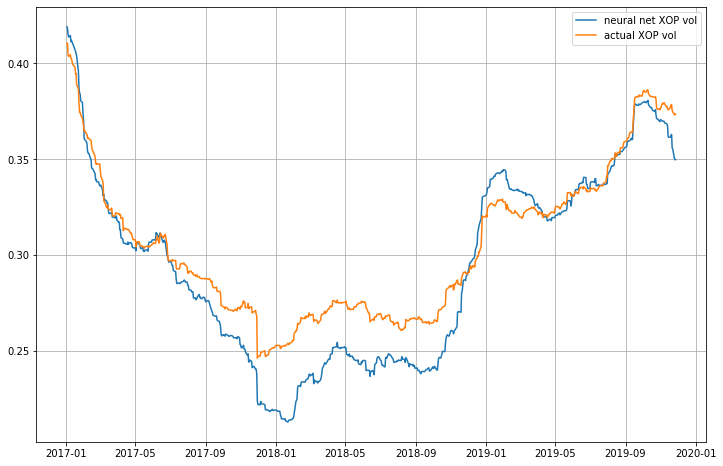

In [33]:
plot(y_test.index, np.sqrt(model.predict(X_test)),label='neural net XOP vol')
#plot(y_test.index, np.sqrt(ols.predict(X_test)),label='ols XOP vol')
plot(np.sqrt(y_test),label='actual XOP vol')
legend(loc='upper right')

In [34]:
# What is the max difference in vol between neural net and actual on the test data?
# I.e. even with the fit above, how far off has the model been? 
np.abs(np.sqrt(y_test) - np.sqrt(model.predict(X_test)).flatten()).max()

0.04180697465328337

In [35]:
# Using OLS to predict OIH variance off XOP variance
ols = linear_model.LinearRegression().fit(variances['XOP'][:'2017-01-01'].values.reshape(-1,1),variances['OIH'][:'2017-01-01'].values)

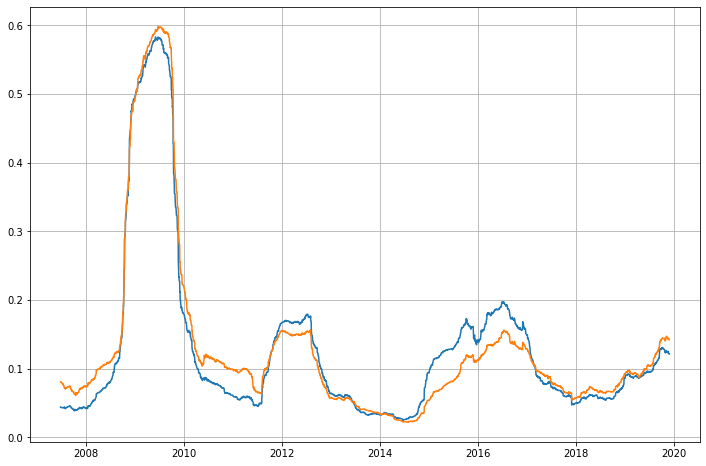

In [36]:
plot(variances.index, ols.predict(variances['XOP'].values.reshape(-1,1)))
plot(variances.index, variances['OIH'])

In [37]:
r2_score(variances['OIH']['2017-01-01':],ols.predict(variances['XOP']['2017-01-01':].values.reshape(-1,1)))

0.8382040823652701

In [38]:
(np.sqrt(ols.predict(variances['XOP']['2017-01-01':].values.reshape(-1,1))) - np.sqrt(variances['OIH']['2017-01-01':])).max()

0.027606168128876785